<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab03_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from PIL import Image

Download an image

In [3]:
!wget -q -O logo.jpeg 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSixRrWNbEVXhVaaYYUQhbWpCa3KbxI65ZoXw&s'

Image is 165 x 225 pixels


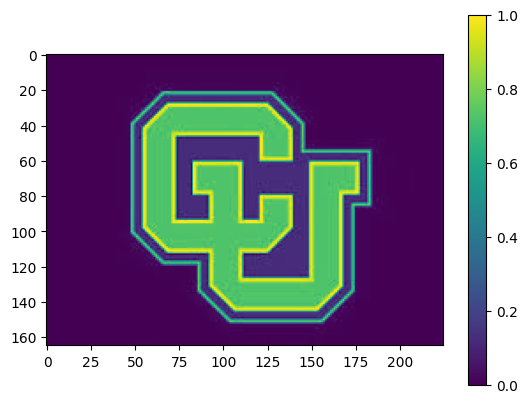

In [4]:
im = Image.open("logo.jpeg")
# print(im.format, im.size, im.mode)
n1,n2 = im.size
# im.show() # or just im  by itself
image = np.array(
    im.convert('L').getdata(), # turns it to grayscale
    dtype=np.float32  # convert to floating point, and use Single not Double since that's default for PyTorch
    ).reshape(im.size[0], im.size[1])

# For the CU logo, let's take just the central part:
image = image[:-60,:]

# and to make it even easier, let's make the image smooth
# image = gaussian_filter(image,sigma=5)

image /= image.max() # put it in [0,1] range, so neural net initialization works
n1,n2 = image.shape
print(f'Image is {n1} x {n2} pixels')
plt.imshow( image )
plt.colorbar()
plt.show()

In [5]:
def trueLabels(X):
  """ Assumes 2D input, typically in [0,1] x [0,1]
  X has size [batch,2]
  Internally, converts the 2D coordinates to 1D indices
    then changes from a continuous value to a discrete value and returns the value of that pixel
  """
  X = np.ravel_multi_index( (np.int64(X[:,0]*n1), np.int64(X[:,1]*n2)), mode='clip', dims=(n1,n2) )
  y = np.ravel(image)[X]
  return torch.from_numpy(y ).unsqueeze(1) # unqueeze makes it size (batch_size,1) rather than (batch_size,)

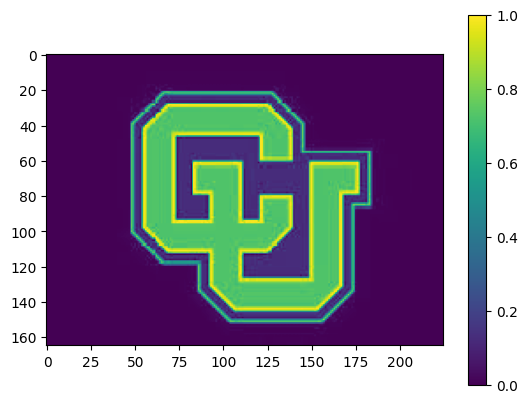

In [6]:
X = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2)
y = trueLabels(X)
plt.imshow(y.detach().numpy().reshape( (n1,n2) ) )
plt.colorbar()
plt.show()

## Define a neural net

Here's a basic neural net that doesn't give good results:

In [7]:
loss_fn  = nn.MSELoss()
inputDim = 2
outputDim  = 1
# activation = nn.GELU() # less stable! but might work better in the end

class MyNet(nn.Module):
    def __init__(self, hidden_features=None, hidden_layers=None, activation = nn.ReLU() ):
        super().__init__()
        if hidden_features is None:
            # default
            width1 = 10
            width2 = 30
            width3 = 50
            width4 = 30
            width5 = 10
            self.net = nn.Sequential( nn.Linear(inputDim,width1),
                activation,   nn.Linear(width1,width2),
                activation,   nn.Linear(width2,width3),
                activation,   nn.Linear(width3,width4),
                activation,   nn.Linear(width4,width5),
                activation,   nn.Linear(width5,1) )
        else:
            # Construct a net as instructed (all hidden layers of the same size)
            self.net = []
            self.net.append(nn.Linear(inputDim, hidden_features))
            self.net.append( activation )
            for i in range(hidden_layers):
                self.net.append(nn.Linear(hidden_features, hidden_features))
                self.net.append( activation )
            self.net.append(nn.Linear(hidden_features, outputDim))
            self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

Here's a better neural net. Thanks to Beckett Hyde who followed the [Implicit Neural Representations with Periodic Activation Functions](https://www.vincentsitzmann.com/siren/) (aka "SIREN") paper (NeurIPS 2020) and their [colab notebook](https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb)

This has two main differences from the simple `MyNet` module above:
- the activation functions are `sin` functions with a given frequency
- and the initialization is special.

In [8]:
from collections import OrderedDict

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        # return output, coords # from the SIREN webpage, but we don't need "coords"
        return output

## Train the neural net
First, using LBFGS

In [9]:
model = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
# model = MyNet()
# model = MyNet( hidden_features = 256, hidden_layers = 3, activation = nn.GELU() )

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'Using {device} device')
# model.to(device)  # NOTE: GPU implementation is not working

# Train with L-BFGS optimizer using full batches (not minibatches)
#   so the only thing stochastic is the initialization
learning_rate = 1
epochs        = 10
optimizer     = torch.optim.LBFGS(model.parameters(),
                                  lr=learning_rate,
                                  history_size=20,
                                  max_iter=10, line_search_fn='strong_wolfe')
lossHistory = []
tol         = 1e-4
size = 256**2
batch_size = size
print('== Training via L-BFGS ==')
for t in range(epochs):
    model.train()
    for batch in range(int(size/batch_size)):
        def closure():
            optimizer.zero_grad()
            X = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2) #.to(device)
            y = trueLabels(X) #.to(device)

            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            if loss.requires_grad:  # since during a linesearch we don't need this...
                loss.backward()
            lossHistory.append( loss.item() )
            return loss

        optimizer.step( closure )
    if lossHistory[-1] < tol:
        print('Reached tolerance, quitting')
        break
    if t < 10 or (t+1) % 5 == 0 :
      print(f"Epoch {t+1:3d}, loss: {lossHistory[-1]:>7f}")

== Training via L-BFGS ==
Epoch   1, loss: 0.028774
Epoch   2, loss: 0.020111
Epoch   3, loss: 0.013665
Epoch   4, loss: 0.007945
Epoch   5, loss: 0.004916
Epoch   6, loss: 0.003491
Epoch   7, loss: 0.002638
Epoch   8, loss: 0.002064
Epoch   9, loss: 0.001636
Epoch  10, loss: 0.001321


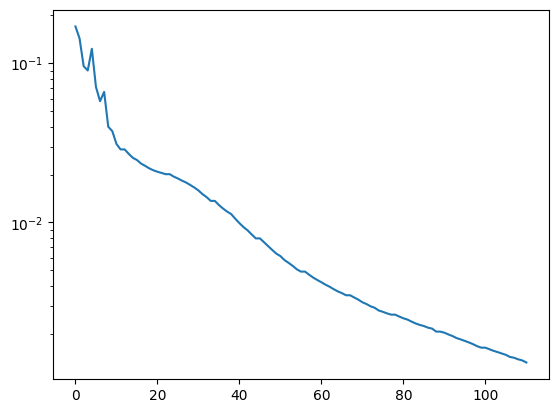

In [10]:
# plt.semilogy(gaussian_filter1d(lossHistory[:],sigma=50)) # smooth it a bit... Lightning will do this for you!
plt.semilogy( lossHistory )
plt.show()

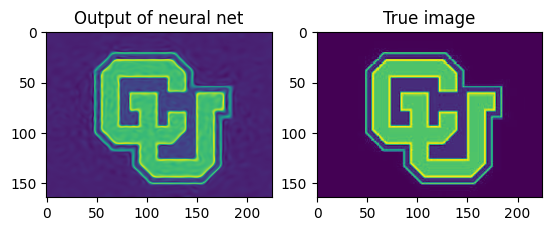

In [11]:
X    = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2)
y    = trueLabels(X)

model.eval()
with torch.no_grad():
    yHat = model(X)

fig, ax = plt.subplots(1,2)
ax[0].imshow(yHat.detach().numpy().reshape( (n1,n2) ) )
ax[0].set_title('Output of neural net')
ax[1].imshow(y.detach().numpy().reshape( (n1,n2) ) )
ax[1].set_title('True image')
plt.show()

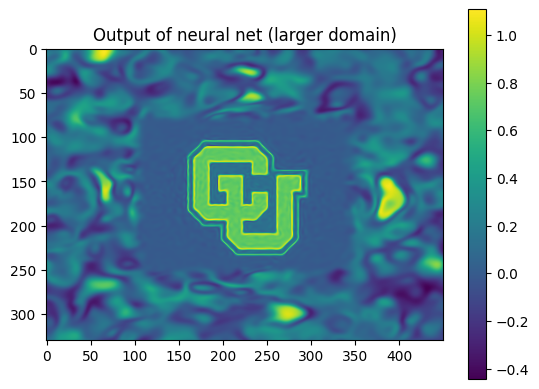

In [12]:
# For fun, we can see what our model predicts *outside* of [0,1] x [0,1]
# N1, N2 = n1, n2
# a, b   = 0, 1
N1, N2 = 2*n1, 2*n2
a, b   = -.5, 1.5
X    = torch.cartesian_prod(torch.linspace(a,b,steps=N1),torch.linspace(a,b,steps=N2) )

model.eval()
with torch.no_grad():
    yHat = model(X)

plt.imshow(yHat.detach().numpy().reshape( (N1,N2) ) )
plt.colorbar()
plt.title('Output of neural net (larger domain)')
plt.show()

### Train with a different optimizer

In [13]:
model = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
# model = MyNet()
# model = MyNet( hidden_features = 256, hidden_layers = 3, activation = nn.GELU() )

learning_rate = 1e-4
epochs        = 10
# optimizer     = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer     = torch.optim.Adam(model.parameters(),lr=learning_rate)
lossHistory = []
size = 256**2
# batch_size = 10
batch_size = 100
tol = 1e-4
print('== Training via SGD or gradient descent or ADAM ==')
for t in range(epochs):
    model.train()
    num_batches = int(size/batch_size)
    runningLoss = 0.
    for batch in range(num_batches):
        # sample in [0,1] x 0,1
        X = torch.cartesian_prod(torch.randn(batch_size),torch.randn(batch_size)) #.to(device)
        y = trueLabels(X) #.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()

        runningLoss += loss.item()



        optimizer.step()
        optimizer.zero_grad()
    lossHistory.append( runningLoss/num_batches )
    if lossHistory[-1] < tol:
        print('Reached tolerance, quitting')
        break
    if t < 10 or (t+1) % 5 == 0 :
      print(f"Epoch {t+1:3d}, loss: {lossHistory[-1]:>7f}")

== Training via SGD or gradient descent or ADAM ==
Epoch   1, loss: 0.002427
Epoch   2, loss: 0.001294
Epoch   3, loss: 0.001090
Epoch   4, loss: 0.001026
Epoch   5, loss: 0.000910
Epoch   6, loss: 0.000856
Epoch   7, loss: 0.000907
Epoch   8, loss: 0.000839
Epoch   9, loss: 0.000869
Epoch  10, loss: 0.000854


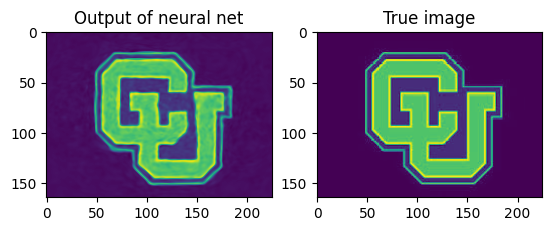

In [14]:
X    = torch.cartesian_prod(torch.arange(0,n1)/n1,torch.arange(0,n2)/n2)
y    = trueLabels(X)

model.eval()
with torch.no_grad():
    yHat = model(X)

fig, ax = plt.subplots(1,2)
ax[0].imshow(yHat.detach().numpy().reshape( (n1,n2) ) )
ax[0].set_title('Output of neural net')
ax[1].imshow(y.detach().numpy().reshape( (n1,n2) ) )
ax[1].set_title('True image')
plt.show()